**NOTE:**

Before running the codes, you need to download the main project folder to the main directory of your Google Drive.

# Libraries and Dataset

Import the necessary libraries and the TensorBoard notebook extension.

In [ ]:
%reset -f
import keras
import tensorflow as tf
from keras import layers
from keras.datasets import mnist
import numpy as np
from numpy import genfromtxt
from matplotlib import pyplot as plt
import matplotlib.image as mpimg 
from keras.callbacks import TensorBoard
from google.colab import files
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from random import randint, seed
from IPython.display import clear_output 
%reload_ext tensorboard

Download MNIST dataset and split it into training, development and test sets and add white Gaussian noise with varying noise levels.

In [ ]:
(x_train_temp, _), (x_test_temp, _) = mnist.load_data()

x_test_temp = x_test_temp[1000:len(x_test_temp)]
# Create noisy data
x_train_temp = x_train_temp.astype('float32') / 255.
x_test_temp = x_test_temp.astype('float32') / 255.
x_train_temp = np.reshape(x_train_temp, (len(x_train_temp), 28, 28, 1))
x_test_temp = np.reshape(x_test_temp, (len(x_test_temp), 28, 28, 1))

x_train_noisy = np.empty([len(x_train_temp),28,28,1])
x_test_noisy = np.empty([len(x_test_temp),28,28,1])

for i in range(len(x_train_temp)):
  noise_factor = np.random.randint(0, 60)/100
  x_train_noisy[i] = x_train_temp[i] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_temp[0].shape)

for i in range(len(x_test_temp)):
  noise_factor = np.random.randint(0, 60)/100
  x_test_noisy[i] = x_test_temp[i] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_temp[0].shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

x_train = np.concatenate([x_train_temp,x_train_noisy]);
y_train = np.concatenate([x_train_temp,x_train_temp]);
x_test = np.concatenate([x_test_temp,x_test_noisy]);
y_test = np.concatenate([x_test_temp,x_test_temp]);

print("Train set size : ", x_train.shape)
print("Train set labels size : ", y_train.shape)
print("Test set size : ", x_test.shape)
print("Test set labels size : ", y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
Train set size :  (120000, 28, 28, 1)
Train set labels size :  (120000, 28, 28, 1)
Test set size :  (18000, 28, 28, 1)
Test set labels size :  (18000, 28, 28, 1)


# Training the CAE image Compressor

In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis = 3)(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis = 3)(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis = 3)(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis = 3)(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoder_output = layers.MaxPooling2D((2, 2), padding='same')(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")

decoder_input = keras.Input(shape=(4, 4, 8), name="encoded_img")
x = layers.Reshape((4, 4, 8))(decoder_input)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis = 3)(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis = 3)(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis = 3)(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization(axis = 3)(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, y_train,
                epochs=15,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

In [ ]:
encoder.summary()

# Testing the CAE compressor

Load the trained models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

encoder = load_model('/content/drive/MyDrive/KABAS-OGUTEN-EE3001-Term-Project/models/encoder.h5')
decoder = load_model('/content/drive/MyDrive/KABAS-OGUTEN-EE3001-Term-Project/models/decoder.h5')

Mounted at /content/drive


Run the trained model to compress images

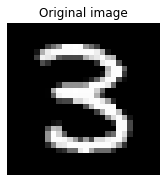

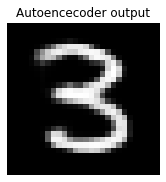

In [ ]:
# Get a test image
index = np.random.randint(0, 1000)
img = x_test[index]

# Plot test image
ax = plt.subplot(1, 2, 1)
plt.imshow(img.reshape(28, 28))
plt.title('Original image')
plt.axis('off')
plt.gray()
plt.show()

# Autoencoder
img = np.reshape(img, (1, 28, 28, 1))
encoded = encoder.predict(img)
decoded = decoder.predict(encoded)

# Show Autoencoder output 
ax = plt.subplot(1, 2, 2)
plt.imshow(decoded.reshape(28, 28))
plt.title('Autoencecoder output')
plt.axis('off')
plt.gray()
plt.show()

Test on noisy images

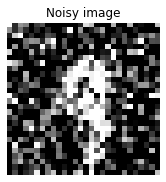

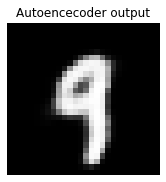

In [ ]:
# Get a test image
index = np.random.randint(0, 1000)
img = x_test[index]

# Adding noise
noise_factor = 0.5
img = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
img = np.clip(img, 0., 1.)

# Show the noisy image
ax = plt.subplot(1, 2, 2)
plt.imshow(img.reshape(28, 28))
plt.title('Noisy image')
plt.axis('off')
plt.gray()
plt.show()

# Autoencoder
img = np.reshape(img, (1, 28, 28, 1))
encoded = encoder.predict(img)
decoded = decoder.predict(encoded)

# Show Autoencoder output 
ax = plt.subplot(1, 2, 2)
plt.imshow(decoded.reshape(28, 28))
plt.title('Autoencecoder output')
plt.axis('off')
plt.gray()
plt.show()

# Testing the accuracy of the CAE compressor

Testing the accuracy of the CAE compressor using the ResNet classifier for different noise levels

In [ ]:
# Load the data set
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Load the ResNet classifier
classification = load_model('/content/drive/MyDrive/KABAS-OGUTEN-EE3001-Term-Project/models/classification.h5')

# Calculate the accuracy
length = 1000
noise_factor = 0.3
correct = 0

for i in range(length):
  img = x_test[i]
  img = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
  img = np.clip(img, 0., 1.)
  img = np.reshape(img, (1, 28, 28, 1))
  encoded = encoder.predict(img)
  decoded = decoder.predict(encoded)
  pre = classification.predict(decoded)
  if np.argmax(pre) == np.argmax(y_test[i]):
    correct = correct + 1
    print(correct)
  clear_output()
  print(i, "/", length)

print("Accuracy: " + str(correct*100/length) + "%")

999 / 1000
Accuracy: 95.2%
